<a href="https://colab.research.google.com/github/utkarshminhas/violence-detection-fyp/blob/main/notebooks/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set dataset paths

In [18]:
original_train_dir = '/content/drive/Shareddrives/Final Year Project/Datasets/RWF-2000/train'
original_val_dir = '/content/drive/Shareddrives/Final Year Project/Datasets/RWF-2000/val'

processed_train_dir = '/content/drive/Shareddrives/Datasets/RWF-2000/processed_train'
processed_val_dir = '/content/drive/Shareddrives/Datasets/RWF-2000/processed_val_and_test'

# raw_rwf_dir = '/content/drive/Shareddrives/Final Year Project/Datasets/Mini-RWF-2000'
# processed_rwf_dir = '/content/drive/Shareddrives/Final Year Project/Datasets/Processed'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Export to frames

In [19]:
import os
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from tqdm import tqdm
import numpy as np
import tensorflow as tf

In [20]:
def generate_base_folders(original_dir, processed_dir):
    if not os.path.exists(processed_dir):
        os.makedirs(processed_dir)

    categories = os.listdir(original_dir)
    
    for category in categories:
        cur_op_dir = os.path.join(processed_dir, category)
        if not os.path.exists(cur_op_dir):
            os.makedirs(cur_op_dir)

def convert_to_frames(original_dir, processed_dir):
    categories = os.listdir(original_dir)

    for category in tqdm(categories):
        videos = os.listdir(os.path.join(original_dir, category))

        for video in tqdm(videos, position=0, leave=True):
            generate_frames(category, video, original_dir, processed_dir)


def get_mask(frame):
    fgbg = cv2.createBackgroundSubtractorMOG2(
           varThreshold=15,
       detectShadows=True
    )

    mog_mask = fgbg.apply(frame)
    median_blur_mask = cv2.medianBlur(mog_mask, 5)
    bilateral_filter_mask = cv2.bilateralFilter(median_blur_mask, 9, 75, 75)
    gaussian_blur_mask = cv2.GaussianBlur(bilateral_filter_mask, (13, 13), 5)

    return gaussian_blur_mask


def generate_frames(category, video, original_dir, processed_dir):
    base_video_name, _ = os.path.splitext(video)
    video_ip_path = os.path.join(original_dir, category, video)
    video_op_dir_path = os.path.join(processed_dir, category, base_video_name)

    if not os.path.exists(video_op_dir_path):
        os.makedirs(video_op_dir_path)

    cap = cv2.VideoCapture(video_ip_path)
    framerate = int(cap.get(5))

    capture_frequency = 5

    while True:
        frame_number = int(cap.get(1))
        success, frame = cap.read()

        if not success or frame is None:
            break

        masked_frame = get_mask(frame)

        if frame_number % capture_frequency == 1:
            exporting_frame_number = int(frame_number / capture_frequency)
            frame_path = os.path.join(video_op_dir_path, "frame_{0:0=3d}.jpg".format(exporting_frame_number))
            cv2.imwrite(frame_path, masked_frame)

        k = cv2.waitKey(30)

        if k == 27 or k == ord('q'):
            break

    cap.release()


In [ ]:
generate_base_folders(original_train_dir, processed_train_dir)
generate_base_folders(original_val_dir, processed_val_dir)

In [ ]:
with tf.device('/device:GPU:0'):
    convert_to_frames(original_train_dir, processed_train_dir)

100%|██████████| 2/2 [2:42:26<00:00, 4873.25s/it]


In [ ]:
with tf.device('/device:GPU:0'):
    convert_to_frames(original_val_dir, processed_val_dir)

100%|██████████| 2/2 [02:08<00:00, 64.00s/it]


# Preprocessing

In [ ]:
# lalalal

# Model

## Some global variables

In [54]:
image_size = (128, 128)

label_to_int = {
    'Fight': 1,
    'NonFight': 0
}

batch_size = 1

## Training and validation generator

In [55]:
def preprocess(img):
    img = cv2.resize(img, image_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img / 255.0

    temp = img
    img = []
    for r in range(len(temp)):
        cur_row = []
        for c in range(len(temp[r])):
            cur_row.append([temp[r][c]])
        img.append(cur_row)
    img = np.array(img)

    return img


def get_data(batch_size, processed_dir):
    data = []
    batch = []

    categories = os.listdir(processed_dir)

    for category in categories:
        videos = os.listdir(os.path.join(processed_dir, category))

        for video in videos:
            video_folder_path = os.path.join(processed_dir, category, video)
            batch.append([video_folder_path, label_to_int.get(category)])

            # If batch size is not a multiple of total number of videos, it will not return it since the if condition will never be satisfied
            if len(batch) == batch_size:
                data.append(batch)
                batch = []

    return data


def data_generator(data):
    for batch in data:
        x_set = []
        y_set = []

        for video, category in batch:
            current_video = []

            frames = os.listdir(video)
            for frame in frames:
                frame_path = os.path.join(video, frame)
                img = cv2.imread(frame_path)
                img = preprocess(img)

                current_video.append(img)

            x_set.append(current_video)
            y_set.append([category])

        x_set = np.array(x_set)
        y_set = np.array(y_set)

        yield (x_set, y_set)

# **DO NOT BATCH THE VALIDATION DATA**

In [56]:
train_data = get_data(batch_size, processed_train_dir)
val_data = get_data(batch_size, processed_val_dir)



In [57]:
print(train_data)

[[['/content/drive/Shareddrives/Datasets/RWF-2000/processed_train/Fight/Ile3EVQA_0', 1]], [['/content/drive/Shareddrives/Datasets/RWF-2000/processed_train/Fight/-1l5631l3fg_0', 1]], [['/content/drive/Shareddrives/Datasets/RWF-2000/processed_train/Fight/EtRfZ2KP_5', 1]], [['/content/drive/Shareddrives/Datasets/RWF-2000/processed_train/Fight/-1l5631l3fg_1', 1]], [['/content/drive/Shareddrives/Datasets/RWF-2000/processed_train/Fight/-1l5631l3fg_2', 1]], [['/content/drive/Shareddrives/Datasets/RWF-2000/processed_train/Fight/0H2s9UJcNJ0_0', 1]], [['/content/drive/Shareddrives/Datasets/RWF-2000/processed_train/Fight/0H2s9UJcNJ0_2', 1]], [['/content/drive/Shareddrives/Datasets/RWF-2000/processed_train/Fight/0H2s9UJcNJ0_3', 1]], [['/content/drive/Shareddrives/Datasets/RWF-2000/processed_train/Fight/0H2s9UJcNJ0_4', 1]], [['/content/drive/Shareddrives/Datasets/RWF-2000/processed_train/Fight/0H2s9UJcNJ0_5', 1]], [['/content/drive/Shareddrives/Datasets/RWF-2000/processed_train/Fight/0lHQ2f0d_0', 1

# Model

## Imports

In [27]:
!pip install tensorflow_addons

In [40]:
from tensorflow.keras import layers
import numpy as np
from keras.layers import TimeDistributed, Conv2D, Dense, MaxPooling2D, \
Flatten, LSTM, Dropout, BatchNormalization
from keras import models
import itertools

import keras
from keras import optimizers
import tensorflow_addons as tfa

## Architecture

In [58]:
input_shape = (30, image_size[0], image_size[1], 1)
num_epochs = 5

val_steps=400//num_epochs
train_steps=1600//num_epochs

In [ ]:
strategy= tf.distribute.MultiWorkerMirroredStrategy()

with strategy.scope():
  model = models.Sequential(
      [
          TimeDistributed(
              Conv2D(32, (3, 3), activation=tf.nn.relu), 
              input_shape=input_shape
          ),
          TimeDistributed(MaxPooling2D((2, 2), strides=(1, 1))),
          TimeDistributed(Conv2D(32, (4, 4), activation=tf.nn.relu)),
          TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))),
          TimeDistributed(Conv2D(32, (4, 4), activation=tf.nn.relu)),
          TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))),
          TimeDistributed(Flatten()),
          Dropout(0.5),
          LSTM(256, return_sequences=False, dropout=0.5, input_shape=input_shape),
          Dense(1, activation=tf.nn.sigmoid)
      ]
  )

model.summary()

In [72]:
gennifer_engineering_trainee = data_generator(train_data)
gennifer_engineering_vallee = data_generator(val_data)

# gennifer_engineering_trainee = itertools.cycle(gennifer_engineering_trainee)
# gennifer_engineering_vallee = itertools.cycle(gennifer_engineering_vallee)

In [74]:
print('Training Data')
X, y = next(gennifer_engineering_trainee)
print(len(train_data))
print(X.shape, y.shape)

print('Validation Data')
X, y = next(gennifer_engineering_vallee)
print(len(val_data))
print(X.shape, y.shape)

1600
(1, 30, 128, 128, 1) (1, 1)
Validation Data
400
(1, 30, 128, 128, 1) (1, 1)


In [75]:
tqdm_callback = tfa.callbacks.TQDMProgressBar()
model_path = 'cnn_lstm_model.h5'

callbacks_list = [
    # tqdm_callback,
    # keras.callbacks.EarlyStopping(monitor=['acc'], patience=3),
    # keras.callbacks.ModelCheckpoint(
    #     filepath=model_path,
    #     monitor='val_loss',
    #     save_best_only=True
    # ),
    # keras.callbacks.ReduceLROnPlateau(
    #     monitor="val_loss",
    #     factor=0.1,
    #     patience=3
    # )
]

optimizer=optimizers.RMSprop(lr=1e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

In [76]:
with tf.device('/device:GPU:0'):
    history = model.fit(
        gennifer_engineering_trainee,
        steps_per_epoch=train_steps,
        validation_data=gennifer_engineering_vallee,
        validation_steps=val_steps,
        epochs=num_epochs,
        # callbacks=callbacks_list,
        batch_size=batch_size,
        use_multiprocessing=True,
        workers=16,
    )

Epoch 1/5
320/320 [==============================] - 461s 1s/step - loss: 0.0156 - acc: 0.9802 - val_loss: 2.5870e-08 - val_acc: 1.0000
Epoch 2/5
320/320 [==============================] - 447s 1s/step - loss: 2.3421e-08 - acc: 1.0000 - val_loss: 2.4210e-08 - val_acc: 1.0000
Epoch 3/5
320/320 [==============================] - 516s 2s/step - loss: 2.6054e-08 - acc: 1.0000 - val_loss: 2.3795e-08 - val_acc: 1.0000
Epoch 4/5
320/320 [==============================] - 551s 2s/step - loss: 2.4966e-08 - acc: 1.0000 - val_loss: 2.3394e-08 - val_acc: 1.0000
Epoch 5/5
320/320 [==============================] - 574s 2s/step - loss: 2.3176e-08 - acc: 1.0000 - val_loss: 2.3395e-08 - val_acc: 1.0000


In [82]:
model.save('/content/drive/Shareddrives/Final Year Project/Saved Model/model.h5',save_format='h5')

model.save(, save_format='h5')

```
total_number_of_videos = batch_size * (steps_per_epoch * epochs)

number_of_batches = total_number_of_videos / batch_size
```

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


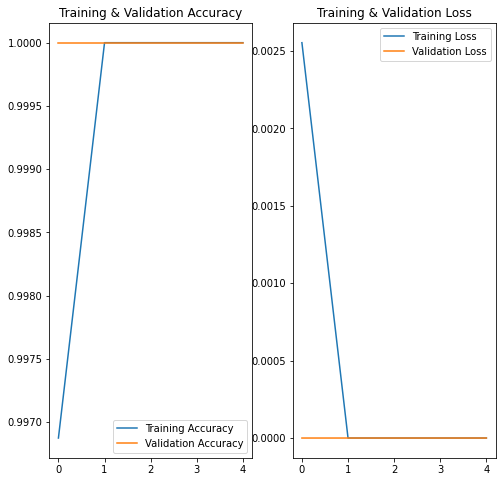

In [93]:
acc = history.history['acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

print(history.history.keys())
epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')

plt.legend(loc='lower right')
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

plt.legend(loc='upper right')
plt.title('Training & Validation Loss')
plt.show()
